<a href="https://colab.research.google.com/github/jppgks/DL-from-Scratch-with-PyTorch/blob/main/Classifying_FashionMNIST_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import torch
from torch import nn
from torch.nn import functional as F

## Data

In [67]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [68]:
img, label = training_data[0]
img.shape

torch.Size([1, 28, 28])

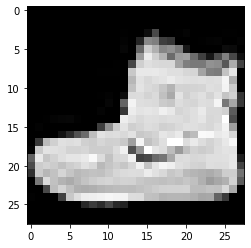

In [69]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(0), cmap='gray')

## Model

In [70]:
img.shape

torch.Size([1, 28, 28])

In [71]:
class ImageClassifier(nn.Module):
  out_channels: int = 32
  kernel_size: int = 3
  stride: int = 1
  padding: int = 1


  def __init__(self, in_channels, input_size, num_classes):
    super(ImageClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
    
    self.activation = nn.ReLU()

    self.pool = nn.MaxPool2d(2, 2)

    self.flatten = nn.Flatten(1, -1)
    self.out = nn.Linear(int(self.out_channels * (input_size / 2) * (input_size / 2)), 10)

  def forward(self, inputs):
    x = inputs
    x = self.conv1(x)
    x = self.activation(x)
    x = self.pool(x)
    out = self.out(self.flatten(x))

    return out

In [72]:
model = ImageClassifier(in_channels=1, input_size=28, num_classes=10)

In [73]:
F.softmax(model(img.unsqueeze(0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1301, 0.1047, 0.0865, 0.1013, 0.0715, 0.1277, 0.0906, 0.0867, 0.0991,
         0.1017]], grad_fn=<SoftmaxBackward0>)

## Train

### Loss

In [74]:
loss = nn.CrossEntropyLoss()

In [75]:
pred = model(img.unsqueeze(0))

In [76]:
loss(pred, torch.tensor([label]))

tensor(2.2853, grad_fn=<NllLossBackward0>)

Cross entropy should equal the negative log likelihood (NLL) between predicted probabilities $p$ and target $y$. The predicted probabilies $p$ are obtained by applying log-softmax on the values predicted by the model. One-hot encoding the label gives a probability vector with all zeros except a 1 on the index of the label $y$. The NLL is reduced to a single term $-p_y*y$, with $y=1$ and $p_y=$ the log-softmax of the value predicted by the model for this label.

In [77]:
-F.log_softmax(pred, dim=1).squeeze()[label]

tensor(2.2853, grad_fn=<NegBackward0>)

Log softmax is simply the log of the softmax:

In [78]:
-torch.log(
    torch.exp(pred.squeeze()[label]) / torch.sum(torch.exp(pred))
)

tensor(2.2853, grad_fn=<NegBackward0>)

### Optimization

In [79]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [80]:
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size)

In [81]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [82]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Does it learn? 🤔

In [83]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.276879  [    0/60000]
loss: 1.964691  [ 6400/60000]
loss: 1.631537  [12800/60000]
loss: 1.550949  [19200/60000]
loss: 1.243538  [25600/60000]
loss: 1.203669  [32000/60000]
loss: 1.130729  [38400/60000]
loss: 1.007335  [44800/60000]
loss: 1.033858  [51200/60000]
loss: 0.957286  [57600/60000]
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.917108 

Epoch 2
-------------------------------
loss: 0.930932  [    0/60000]
loss: 0.964112  [ 6400/60000]
loss: 0.717423  [12800/60000]
loss: 0.958476  [19200/60000]
loss: 0.792887  [25600/60000]
loss: 0.816744  [32000/60000]
loss: 0.822801  [38400/60000]
loss: 0.743424  [44800/60000]
loss: 0.815763  [51200/60000]
loss: 0.783646  [57600/60000]
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.735975 

Epoch 3
-------------------------------
loss: 0.699690  [    0/60000]
loss: 0.800951  [ 6400/60000]
loss: 0.548993  [12800/60000]
loss: 0.830462  [19200/60000]
loss: 0.703342  [25600/60000]
loss: 0.716799  [32000/600

It does! 🥳

## Inference

In [88]:
imgs, labels = next(iter(test_dataloader))

In [89]:
labels_pred = model(imgs)

In [90]:
labels

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])

In [92]:
labels_pred.argmax(1)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 0, 7, 7, 5,
        1, 2, 4, 3, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 9, 6, 5, 2, 1,
        4, 6, 2, 2, 5, 6, 4, 2, 8, 4, 8, 0, 7, 7, 8, 5])